# Notebook to parse fasta files and merge sequences with layout

## Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
import numpy as np

## Specify paths

In [2]:
### Input
fasta_files = snakemake.input.fasta_files
layout_path = snakemake.input.expected_mutants
stats_path = snakemake.input.read_stats

### Output
# Dataframes
rcdf_path = snakemake.output.read_counts
# Plots
unexp_rc_plot = snakemake.output.unexp_rc_plot
rc_filter_plot = snakemake.output.rc_filter_plot

## Specify parameters

In [3]:
exp_rc_per_sample = snakemake.params.exp_rc_per_sample

## Parse fasta files (with read count)

In [4]:
seq_l = []

for f in fasta_files:
    
    # Note: In the next line, the double split should catch file (base) names regardless of the platform
    # Should still work when run with snakemake (no paths)
    sample_name = f.split('/')[-1].split('\\')[-1].split('_aggregated.fasta')[0]
    
    with open(f, 'r') as file:
        entries = file.read().split('>')[1:]

    readcount = [int(x.split('size=')[1].split('\n')[0]) for x in entries]
    seqs = [x.split('size=')[1].split('\n', 1)[1].replace('\n', '') for x in entries]
    fasta_df = pd.DataFrame(list(zip(seqs, readcount)), columns=['nt_seq','readcount'])
    fasta_df['Sample_name'] = sample_name
    seq_l.append(fasta_df)
    
master_seq = pd.concat(seq_l, ignore_index=True)
master_seq

,nt_seq,readcount,Sample_name
0,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,97569,SC_alp_r2_F3_T0
1,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,3483,SC_alp_r2_F3_T0
2,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,3272,SC_alp_r2_F3_T0
3,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,3220,SC_alp_r2_F3_T0
4,GACATGTGTACTGGTGCCATTATTATGTACGGGATCCCAAGATGTG...,2473,SC_alp_r2_F3_T0
...,...,...,...
1340970,GTCTTAGGTAGAGGTCACAACATGAGATTCCAAAAGGGTTCTGCCA...,2,SC_alp_r2_F2_T0
1340971,TCTTTAGGTAGAGGTCACAACATGAGATTCCAAAAGGGTTCTGCCA...,2,SC_alp_r2_F2_T0
1340972,GTCTTAGGTAGAGGTCACAACATGAGATTCCAAAAGGGTTCTGCCA...,2,SC_alp_r2_F2_T0
1340973,GTCTTAGGTAGAGGTCACCTCATGAGATTCCAAAAGGGTTCTGCCA...,2,SC_alp_r2_F2_T0


## Compare with expected variants and annotate

In [5]:
master_layout = pd.read_csv(layout_path, index_col=0, dtype={'WT': 'boolean', # Boolean type supports missing data
                                                             'pos':str, 'aa_pos':str}) # pos and aa_pos contain mixed types because of the nucleotide WT - very important when pivoting later on
master_layout

,Sample_name,Pos_start,Pos_stop,Mutated_seq,Species,Mating_type,Replicate,Fragment,Timepoint,nt_seq,WT,pos,aa_pos,alt_codons,alt_aa,aa_seq,Nham_codons,Nham_nt,Nham_aa
0,CN_a_r1_F1_T0,2,71,CN_F1,CN,a,r1,F1,T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,True,non-applicable,non-applicable,non-applicable,non-applicable,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0,0,0
1,CN_a_r2_F1_T0,2,71,CN_F1,CN,a,r2,F1,T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,True,non-applicable,non-applicable,non-applicable,non-applicable,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0,0,0
2,CN_alp_r1_F1_T0,2,71,CN_F1,CN,alp,r1,F1,T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,True,non-applicable,non-applicable,non-applicable,non-applicable,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0,0,0
3,CN_alp_r2_F1_T0,2,71,CN_F1,CN,alp,r2,F1,T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,True,non-applicable,non-applicable,non-applicable,non-applicable,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0,0,0
4,CN_a_r1_F1_T1,2,71,CN_F1,CN,a,r1,F1,T1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,True,non-applicable,non-applicable,non-applicable,non-applicable,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420427,SC_alp_r2_F3_T3,92,158,SC_F3,SC,alp,r2,F3,T3,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,<NA>,66,158,AGG,R,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1,3,1
420428,SC_alp_r2_F3_T3,92,158,SC_F3,SC,alp,r2,F3,T3,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,<NA>,66,158,GGT,G,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1,2,1
420429,SC_alp_r2_F3_T3,92,158,SC_F3,SC,alp,r2,F3,T3,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,<NA>,66,158,GGC,G,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1,2,1
420430,SC_alp_r2_F3_T3,92,158,SC_F3,SC,alp,r2,F3,T3,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,<NA>,66,158,GGA,G,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1,1,1


In [6]:
comparedf = pd.merge(left=master_layout, right=master_seq, how='outer', on=['Sample_name','nt_seq'], indicator='Location')
covered_df = comparedf[comparedf.Location == 'both']
covered_df.to_csv(rcdf_path)

## Coverage of expected variants (ratio of unique expected sequences) at T0

In [7]:
expected_df = covered_df[covered_df.Timepoint == 'T0'].groupby('Sample_name').size().reset_index(name='unique_seq_variants')
expected_df['unique_expected_variants'] = master_layout[master_layout.Sample_name.isin(expected_df.Sample_name.unique())].groupby('Sample_name').size().values
expected_df['unique_variants_%'] = expected_df['unique_seq_variants'] / expected_df['unique_expected_variants']
expected_df

,Sample_name,unique_seq_variants,unique_expected_variants,unique_variants_%
0,CN_a_r1_F1_T0,4292,4411,0.973022
1,CN_a_r1_F2_T0,4273,4474,0.955074
2,CN_a_r1_F3_T0,4111,4474,0.918865
3,CN_a_r2_F1_T0,4294,4411,0.973475
4,CN_a_r2_F2_T0,4276,4474,0.955744
5,CN_a_r2_F3_T0,4130,4474,0.923111
6,CN_alp_r1_F1_T0,4238,4411,0.960780
7,CN_alp_r1_F2_T0,4172,4474,0.932499
8,CN_alp_r1_F3_T0,4087,4474,0.913500
9,CN_alp_r2_F1_T0,4261,4411,0.965994


## Read count of unexpected variants

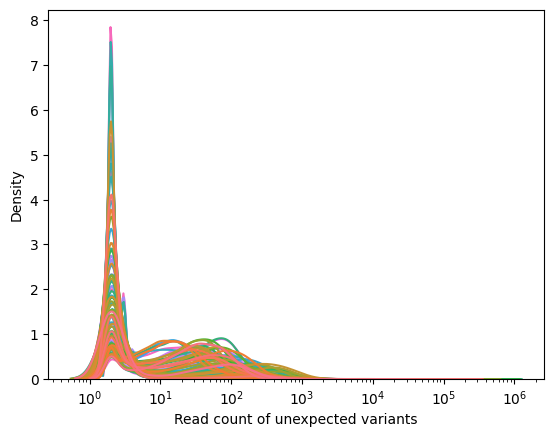

In [8]:
sns.kdeplot(data=comparedf[comparedf.Location == 'right_only'], x='readcount',
            hue='Sample_name', common_norm=False, log_scale=True,
            legend=False
           )
plt.xlabel('Read count of unexpected variants')
plt.savefig(unexp_rc_plot, format='svg', dpi=300)

In [9]:
unexpected_df = comparedf[comparedf.Location == 'right_only'].groupby('Sample_name')[['readcount']].sum()
unexpected_df['total_rc'] = master_seq.groupby('Sample_name')[['readcount']].sum().readcount
unexpected_df['%rc_unexp'] = unexpected_df['readcount'] / unexpected_df['total_rc']
unexpected_df.sort_values(by=['%rc_unexp','Sample_name'], ascending=[False,True]).head(3)

,readcount,total_rc,%rc_unexp
Sample_name,,,
CN_alp_r2_F3_T3,1645790.0,3180655,0.517437
CN_alp_r1_F3_T3,1462732.0,2845101,0.514123
CN_alp_r1_F3_T2,1184093.0,2391233,0.495181


The following command can be used to explore why the sequence is unexpected:
```
comparedf[(comparedf.Location == 'right_only') & (comparedf.Sample_name == 'CN_a_r2_F2_T0')].iloc[0].nt_seq
```

## Show overall read filtering steps

In [10]:
stats = pd.read_csv(stats_path, index_col=0)[['Total_raw_reads','Total_trimmed_reads','Total_merged_reads','Nb_singletons']]
# In the following steps, the column names refer to the total number of reads lost at the specified step
stats['Trimming'] = stats['Total_raw_reads'] - stats['Total_trimmed_reads']
stats['Merging'] =  stats['Total_trimmed_reads'] - stats['Total_merged_reads']
stats['Aggregating'] = stats['Nb_singletons']
stacked_data = pd.concat([stats,
                          unexpected_df[['readcount']].rename(columns={'readcount':'Unexpected'}),
                         ], axis=1)
stacked_data['OK'] = stacked_data['Total_raw_reads'] - stacked_data[['Trimming','Merging','Aggregating','Unexpected']].sum(axis=1)
stacked_data.drop(['Total_raw_reads','Total_trimmed_reads','Total_merged_reads','Nb_singletons'], axis=1, inplace=True)
stacked_data.sort_index(inplace=True)
stacked_data

,Trimming,Merging,Aggregating,Unexpected,OK
CN_a_r1_F1_T0,6423,2825,41956,298687.0,1180648.0
CN_a_r1_F1_T1,8204,6037,68711,585378.0,1348029.0
CN_a_r1_F1_T2,11932,7833,88153,923285.0,1667163.0
CN_a_r1_F1_T3,8143,7318,90536,707388.0,1225208.0
CN_a_r1_F2_T0,25446,1951,25656,260719.0,998621.0
...,...,...,...,...,...
SC_alp_r2_F2_T3,29370,2326,54923,91318.0,1150785.0
SC_alp_r2_F3_T0,12961,1541,48052,45877.0,1318601.0
SC_alp_r2_F3_T1,5855,536,11125,35401.0,567673.0
SC_alp_r2_F3_T2,11401,1518,52524,83498.0,1079601.0


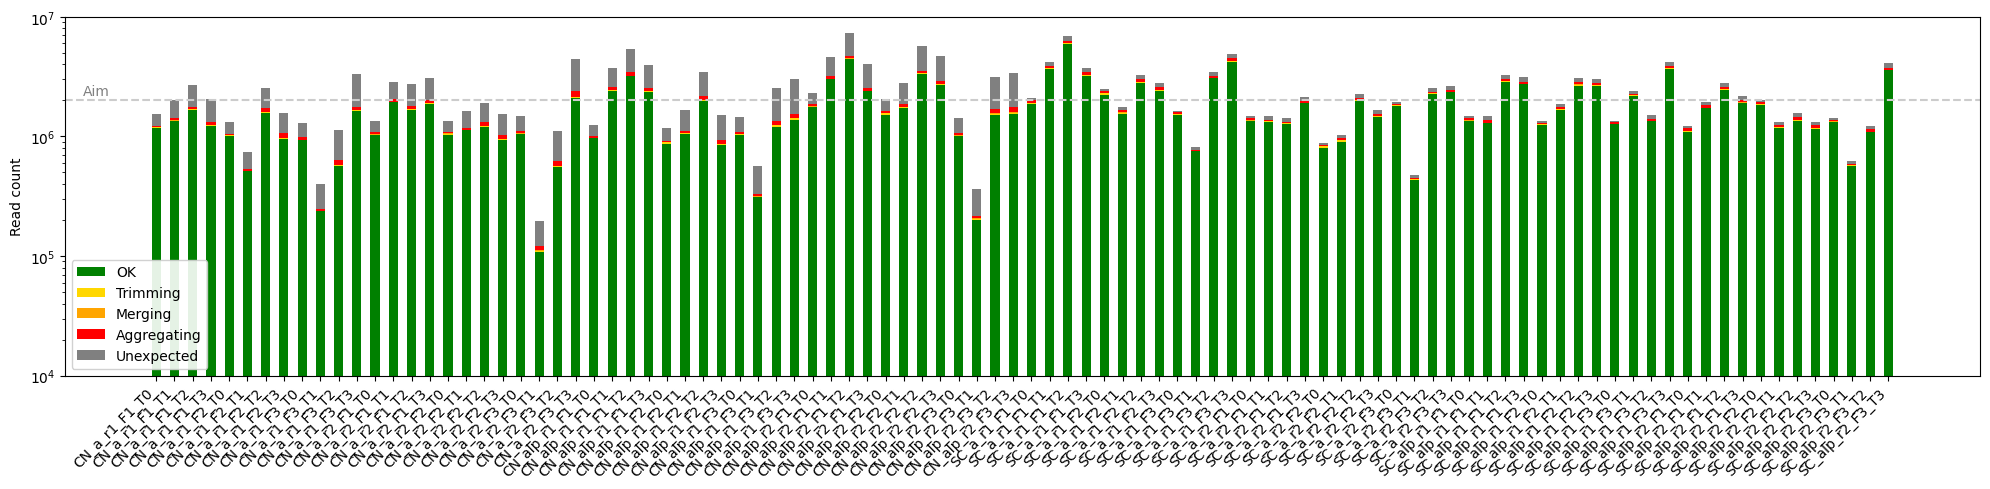

In [11]:
samples = stacked_data.index.to_list()
width = .5
color_dict = {'OK':'green',
              'Trimming':'gold',
              'Merging':'orange',
              'Aggregating':'red',
              'Unexpected':'grey'
             }

f, ax = plt.subplots(figsize=(20,5))
bottom = np.zeros(len(stacked_data))

for l in color_dict.keys():
    p = ax.bar(samples, stacked_data[l].values, width, label=l, bottom=bottom, color=color_dict[l])
    bottom += stacked_data[l].values

ax.set_yscale('log', base=10)
ax.set(ylim=(1e4,1e7), ylabel='Read count')

ax.axhline(y=exp_rc_per_sample, linestyle='--', color='.8')
ax.annotate('Aim', (-4, 1.1*exp_rc_per_sample), color='.5')

ax.xaxis.set_ticks(samples)
ax.set_xticklabels(samples, rotation=45, ha='right')
ax.legend(framealpha=.9)

plt.tight_layout()
plt.savefig(rc_filter_plot, format='svg', dpi=300)
plt.show()